# Real-Time E-commerce Data Pipeline with Spark ETL

## Project Overview

In this project, you will design and implement an ETL (Extract, Transform, Load) pipeline for a hypothetical e-commerce platform named **ShopEase**. The platform generates massive amounts of data daily, including user interactions, transactions, and inventory updates. Your task is to process this data using Apache Spark to derive meaningful insights and support real-time analytics.

## Project Requirements

You are required to perform the following tasks using Apache Spark (preferably with PySpark or Scala):

### 1. Data Ingestion
- **Batch Data:**
  - Load historical data from large CSV and JSON files stored in your local file system.
- **Real-Time Data:**
  - Simulate and ingest streaming data from a Kafka topic representing live user activity logs.

### 2. Data Processing and Transformation
- **Using RDDs:**
  - Perform a transformation to filter out any corrupted or incomplete records from the transaction data.
  - Implement a custom transformation to anonymize user IDs for privacy compliance.
- **Using DataFrames:**
  - Clean and standardize inventory data (e.g., handling missing values, normalizing text).
  - Join user activity logs with transaction records to analyze user behavior leading to purchases.
- **Using Spark SQL:**
  - Create temporary views and execute SQL queries to compute:
    - Top 10 most purchased products in the last month.
    - Monthly revenue trends.
    - Inventory turnover rates.

### 3. Real-Time Streaming Processing (Optional but Recommended)
- Set up a Spark Streaming job to process incoming user activity logs.
- Compute real-time metrics such as:
  - Active users per minute.
  - Real-time conversion rates.
  - Detect and alert on unusual spikes in specific user activities.

### 4. Data Storage
- Store the transformed data into appropriate storage systems:
  - Use Parquet format for batch-processed data in a local data lake.
  - Use an in-memory data store like Redis or a database like PostgreSQL for real-time metrics.

### 5. Performance Optimization
- Optimize Spark jobs for better performance by:
  - Caching intermediate DataFrames where necessary.
  - Tuning Spark configurations (e.g., partition sizes, executor memory).
  - Using appropriate join strategies.

### 6. Documentation and Reporting
- Document the ETL pipeline architecture.
- Provide sample dashboards or reports (using Spark's built-in visualization) showcasing the insights derived.


## Questions & Requirements

### 1. Data Ingestion
- **Q1:** How did you ingest the batch and real-time data? Provide code snippets demonstrating the loading of data using RDDs and DataFrames.

### 2. Data Cleaning and Transformation
- **Q2:** Describe the transformations applied to the transaction data using RDDs. How did you ensure data quality and privacy?

### 3. DataFrame Operations
- **Q3:** How did you clean and standardize the inventory data using DataFrames? Provide examples of handling missing values and normalizing text fields.

### 4. Spark SQL Queries
- **Q4:** Present the Spark SQL queries used to calculate the top 10 most purchased products, monthly revenue trends, and inventory turnover rates.

### 5. Real-Time Processing
- **Q5:** If implemented, explain how the real-time streaming was set up. What metrics were computed in real-time, and how were they stored/displayed?

### 6. Performance Optimization
- **Q6:** What strategies did you employ to optimize the performance of your Spark jobs? Provide examples of configuration settings or code optimizations.

### 7. Reporting
- **Q7:** Show sample outputs or dashboards that visualize the insights derived from the ETL pipeline.


In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession

# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("Batch Data Ingestion") \
    .getOrCreate()

# Step 2: Define paths to the CSV and JSON files
csv_file_path1 = "/content/large_customer_feedback.csv"
csv_file_path2 = "/content/large_transactions.csv"
json_file_path = "/content/large_inventory_reformatted.json"

# Step 3: Load the datasets into DataFrames
# Loading customer feedback CSV
feedback_df = spark.read.csv(csv_file_path1, header=True, inferSchema=True)

# Loading transactions CSV
transactions_df = spark.read.csv(csv_file_path2, header=True, inferSchema=True)

# Loading inventory JSON
inventory_df = spark.read.json(json_file_path)

# Step 4: Show sample data from the DataFrames
feedback_df.show(5)
transactions_df.show(5)
inventory_df.show(5)


+-------+----------+------+--------------------+-----------+
|user_id|product_id|rating|              review|review_date|
+-------+----------+------+--------------------+-----------+
|   9320|      1971|     4|Review text for p...| 2023-01-11|
|  64245|      3664|     4|Review text for p...| 2023-01-23|
|  37341|      7419|     4|Review text for p...| 2023-08-14|
|  43430|      6536|     2|Review text for p...| 2023-12-29|
|   6848|      3038|     1|Review text for p...| 2023-08-03|
+-------+----------+------+--------------------+-----------+
only showing top 5 rows

+--------------+-------+----------+--------+------+----------------+
|transaction_id|user_id|product_id|quantity|amount|transaction_date|
+--------------+-------+----------+--------+------+----------------+
|             1|   5388|      9152|       9|305.67|      2023-01-07|
|             2|  31656|      5763|       1|184.31|      2023-05-16|
|             3|  36725|      4733|       4|  7.66|      2023-01-20|
|           

In [3]:
import hashlib

# Convert transactions DataFrame to RDD
transactions_rdd = transactions_df.rdd

# Step 3: Filter out corrupted records (e.g., missing transaction_id or amount)
cleaned_rdd = transactions_rdd.filter(lambda row: row['transaction_id'] is not None and row['amount'] is not None)

# Step 4: Write a function to anonymize user IDs using Hashing
def anonymize(record):
    user_id = record['user_id']
    hashed_user_id = hashlib.sha256(str(user_id).encode()).hexdigest()  # Hash the user_id
    return (record['transaction_id'], hashed_user_id, record['product_id'], record['quantity'], record['amount'], record['transaction_date'])

# Apply anonymization
anonymized_rdd = cleaned_rdd.map(anonymize)

# Step 5: Convert back to DataFrame
cleaned_transactions_df = anonymized_rdd.toDF(["transaction_id", "user_id", "product_id", "quantity", "amount", "transaction_date"])

# Display cleaned and anonymized data
cleaned_transactions_df.show(5)

+--------------+--------------------+----------+--------+------+----------------+
|transaction_id|             user_id|product_id|quantity|amount|transaction_date|
+--------------+--------------------+----------+--------+------+----------------+
|             1|b797d397acb6b79e3...|      9152|       9|305.67|      2023-01-07|
|             2|3911f43de537d6765...|      5763|       1|184.31|      2023-05-16|
|             3|a0127a90205f9ca56...|      4733|       4|  7.66|      2023-01-20|
|             4|3ec95a5c41362c498...|      4207|       1|411.73|      2023-04-19|
|             5|90ee0ca050e4b8892...|      1914|       5|499.21|      2023-08-17|
+--------------+--------------------+----------+--------+------+----------------+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import lower

# Clean the inventory data (e.g., handle missing values, normalize text)
clean_inventory_df = inventory_df.na.fill({'stock_level': 0})  # Fill missing stock levels with 0

# Normalize product names (convert to lower case)
clean_inventory_df = clean_inventory_df.withColumn("product_name", lower(inventory_df['product_name']))

# Display the cleaned inventory data
clean_inventory_df.show(5)

+------+----------+------------+-----------+
| price|product_id|product_name|stock_level|
+------+----------+------------+-----------+
| 91.89|         1|   product_1|         61|
|  9.75|         2|   product_2|        553|
|182.89|         3|   product_3|        328|
|148.38|         4|   product_4|        347|
| 78.17|         5|   product_5|        180|
+------+----------+------------+-----------+
only showing top 5 rows



In [5]:
from pyspark.sql.functions import col, lower, trim

# Step 1: Clean inventory data by handling missing values and normalizing text
cleaned_inventory_df = inventory_df.dropna(subset=["stock_level"]) \
                                   .withColumn("product_name", lower(trim(col("product_name"))))

# Display cleaned inventory data
cleaned_inventory_df.show(5)


# Step 2: Perform a join operation to combine data
# Join on 'product_id'
joined_df = transactions_df.join(cleaned_inventory_df, on="product_id", how="inner")

# Display the joined DataFrame
joined_df.show(5)

+------+----------+------------+-----------+
| price|product_id|product_name|stock_level|
+------+----------+------------+-----------+
| 91.89|         1|   product_1|         61|
|  9.75|         2|   product_2|        553|
|182.89|         3|   product_3|        328|
|148.38|         4|   product_4|        347|
| 78.17|         5|   product_5|        180|
+------+----------+------------+-----------+
only showing top 5 rows

+----------+--------------+-------+--------+------+----------------+-----+------------+-----------+
|product_id|transaction_id|user_id|quantity|amount|transaction_date|price|product_name|stock_level|
+----------+--------------+-------+--------+------+----------------+-----+------------+-----------+
|      9152|             1|   5388|       9|305.67|      2023-01-07|238.7|product_9152|        871|
|      5763|             2|  31656|       1|184.31|      2023-05-16|91.52|product_5763|        252|
|      4733|             3|  36725|       4|  7.66|      2023-01-20|33

In [6]:
cleaned_inventory_df_copy = cleaned_inventory_df

In [7]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import random

# Step 1: Define a list of random categories
categories_list = ['Electronics', 'Clothing', 'Toys', 'Books', 'Food']

# Step 2: Create a UDF to return a random category from the list
def get_random_category():
    return random.choice(categories_list)

# Register the UDF
random_category_udf = udf(get_random_category, StringType())

# Step 3: Add the 'categories' column with random values to the DataFrame
cleaned_inventory_df_copy = cleaned_inventory_df_copy.withColumn('category', random_category_udf())

# Step 4: Verify the changes
cleaned_inventory_df_copy.show(truncate=False)


+------+----------+------------+-----------+-----------+
|price |product_id|product_name|stock_level|category   |
+------+----------+------------+-----------+-----------+
|91.89 |1         |product_1   |61         |Food       |
|9.75  |2         |product_2   |553        |Electronics|
|182.89|3         |product_3   |328        |Clothing   |
|148.38|4         |product_4   |347        |Food       |
|78.17 |5         |product_5   |180        |Toys       |
|61.26 |6         |product_6   |741        |Books      |
|415.13|7         |product_7   |987        |Clothing   |
|61.42 |8         |product_8   |467        |Toys       |
|60.98 |9         |product_9   |975        |Food       |
|201.41|10        |product_10  |724        |Books      |
|401.51|11        |product_11  |601        |Clothing   |
|407.02|12        |product_12  |914        |Toys       |
|146.99|13        |product_13  |181        |Electronics|
|196.18|14        |product_14  |943        |Clothing   |
|161.75|15        |product_15  

In [8]:
transactions_df.createOrReplaceTempView("transactions")

# Query 1: Find the maximum transaction date
max_date_df = spark.sql("""
    SELECT MAX(transaction_date) AS last_date
    FROM transactions
""")

# Extract the maximum date
max_date_row = max_date_df.collect()[0]
last_date = max_date_row['last_date']

# Query 2: Extract year and month from the last date
year_month_df = spark.sql(f"""
    SELECT YEAR('{last_date}') AS last_year, MONTH('{last_date}') AS last_month
""")

# Show the year and month of the last date
year_month_df.show()


+---------+----------+
|last_year|last_month|
+---------+----------+
|     2023|        12|
+---------+----------+



In [9]:
cleaned_transactions_df.createOrReplaceTempView("transactions")
cleaned_inventory_df.createOrReplaceTempView("inventory")
joined_df.createOrReplaceTempView("joined_data")

# Define the year and month
last_year = 2023
last_month = 12

# Query: Top 10 most purchased products in the last month
top_products_query = f"""
    SELECT product_id, SUM(quantity) AS total_quantity
    FROM transactions
    WHERE YEAR(transaction_date) = {last_year}
    AND MONTH(transaction_date) = {last_month}
    GROUP BY product_id
    ORDER BY total_quantity DESC
    LIMIT 10
"""

# Execute the query and get the DataFrame
top_products_df = spark.sql(top_products_query)

# Display the results
top_products_df.show()

+----------+--------------+
|product_id|total_quantity|
+----------+--------------+
|       499|            96|
|      9050|            78|
|      4677|            71|
|      9162|            70|
|       629|            69|
|      9906|            67|
|      8113|            66|
|      5912|            66|
|      8220|            64|
|      8827|            64|
+----------+--------------+



In [10]:
# Query 2: Monthly Revenue Trends
monthly_revenue_query = """
    SELECT month(transaction_date) AS month, year(transaction_date) AS year, SUM(amount) AS total_revenue
    FROM transactions
    GROUP BY year, month
    ORDER BY year, month
"""

# Execute the query and get the DataFrame
monthly_revenue_df = spark.sql(monthly_revenue_query)

# Display the results
monthly_revenue_df.show()

+-----+----+-----------------+
|month|year|    total_revenue|
+-----+----+-----------------+
|    1|2023|8810177.479999961|
|    2|2023|       8008975.65|
|    3|2023| 8874502.40000003|
|    4|2023|8547512.790000033|
|    5|2023|8790195.020000005|
|    6|2023|8579047.470000008|
|    7|2023|8796873.599999983|
|    8|2023|8726672.809999961|
|    9|2023|8466056.030000001|
|   10|2023|8865992.460000044|
|   11|2023|8583650.259999983|
|   12|2023|8534291.940000005|
+-----+----+-----------------+



In [11]:
# Query 3: Inventory Turnover Rates
turnover_rate_query = """
    SELECT j.product_id, j.product_name, SUM(j.quantity) AS total_sold, i.stock_level,
           (SUM(j.quantity) / i.stock_level) AS turnover_rate
    FROM joined_data j
    JOIN inventory i ON j.product_id = i.product_id
    GROUP BY j.product_id, j.product_name, i.stock_level
    HAVING i.stock_level > 0
    ORDER BY turnover_rate DESC
"""

# Execute the query and get the DataFrame
turnover_rate_df = spark.sql(turnover_rate_query)

# Display the results
turnover_rate_df.show()

+----------+------------+----------+-----------+-----------------+
|product_id|product_name|total_sold|stock_level|    turnover_rate|
+----------+------------+----------+-----------+-----------------+
|      9501|product_9501|       296|          1|            296.0|
|      7567|product_7567|       278|          1|            278.0|
|      4373|product_4373|       268|          1|            268.0|
|      1284|product_1284|       259|          1|            259.0|
|      7759|product_7759|       259|          1|            259.0|
|      2821|product_2821|       254|          1|            254.0|
|      3135|product_3135|       235|          1|            235.0|
|      2871|product_2871|       229|          1|            229.0|
|      9021|product_9021|       225|          1|            225.0|
|        40|  product_40|       212|          1|            212.0|
|      1467|product_1467|       208|          1|            208.0|
|      6771|product_6771|       203|          1|            20

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

spark = SparkSession.builder \
    .appName("PerformanceOptimization") \
    .getOrCreate()

# Access the SparkContext from the SparkSession
sc = spark.sparkContext



In [13]:
from pyspark.sql.functions import broadcast

# Cache DataFrames if they will be used multiple times
transactions_df.cache()
inventory_df.cache()

# Repartition DataFrames for optimal join performance
transactions_df_repartitioned = transactions_df.repartition(10, "product_id")
inventory_df_repartitioned = inventory_df.repartition(10, "product_id")

# Use Broadcast Join for small DataFrames (if applicable)
# Assuming inventory_df is the smaller DataFrame
joined_df_optimized =cleaned_inventory_df.join(broadcast(cleaned_transactions_df), on="product_id" , how="inner")
# Display the optimized joined DataFrame
joined_df_optimized.show(5)



+----------+-----+------------+-----------+--------------+--------------------+--------+------+----------------+
|product_id|price|product_name|stock_level|transaction_id|             user_id|quantity|amount|transaction_date|
+----------+-----+------------+-----------+--------------+--------------------+--------+------+----------------+
|         1|91.89|   product_1|         61|        383888|b002f929e5acc32ca...|       6|166.72|      2023-02-13|
|         1|91.89|   product_1|         61|        365541|a6db9e5506ffb6452...|       2|281.87|      2023-05-23|
|         1|91.89|   product_1|         61|        335728|ae585b0ca509d2aff...|       6|337.42|      2023-10-24|
|         1|91.89|   product_1|         61|        333227|023b95023ad71f0af...|       4|450.58|      2023-07-07|
|         1|91.89|   product_1|         61|        329257|b67e21816864c4f6a...|       3|297.87|      2023-11-15|
+----------+-----+------------+-----------+--------------+--------------------+--------+------+-

In [14]:

# Save DataFrame in Parquet format
cleaned_transactions_df.write.parquet("/home/shorokatwa14/Documents/transactions1.parquet", mode="overwrite")
cleaned_inventory_df.write.parquet("/home/shorokatwa14/Documents/inventory2.parquet", mode="overwrite")


In [15]:
!pip install redis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 12.8 MB/s eta 0:00:00


In [16]:
# Step 3: Write the SQL query for top 10 products by total sales
top_products_query = """
SELECT i.product_name, SUM(t.amount) as total_sales
FROM transactions t
JOIN inventory i ON t.product_id = i.product_id
GROUP BY i.product_name
ORDER BY total_sales DESC
LIMIT 10
"""

# Step 4: Execute the SQL query
top_products_df = spark.sql(top_products_query)

# Step 5: Convert the resulting Spark DataFrame to a Pandas DataFrame
top_products_pd = top_products_df.toPandas()

# Optional: Preview the result
print(top_products_pd.head(10))


   product_name  total_sales
0  product_5996     17903.02
1  product_6875     17633.34
2  product_8280     17439.48
3   product_124     17189.98
4  product_1853     17121.56
5  product_2873     17098.04
6  product_6824     17048.58
7  product_5903     16991.87
8  product_6887     16697.40
9  product_9164     16661.15


In [17]:
# Spark SQL query to get monthly revenue trend
revenue_trend_query = """
SELECT YEAR(t.transaction_date) as year, MONTH(t.transaction_date) as month, SUM(t.amount) as revenue
FROM transactions t
GROUP BY YEAR(t.transaction_date), MONTH(t.transaction_date)
ORDER BY year, month
"""

# Execute the SQL query
revenue_trend_df = spark.sql(revenue_trend_query)

# Convert to Pandas for visualization
revenue_trend_pd = revenue_trend_df.toPandas()

print(revenue_trend_pd.head(10))


   year  month     revenue
0  2023      1  8810177.48
1  2023      2  8008975.65
2  2023      3  8874502.40
3  2023      4  8547512.79
4  2023      5  8790195.02
5  2023      6  8579047.47
6  2023      7  8796873.60
7  2023      8  8726672.81
8  2023      9  8466056.03
9  2023     10  8865992.46


In [18]:
cleaned_inventory_df_copy.createOrReplaceTempView("inventory1")


# Spark SQL query to calculate turnover rates by product category
inventory_turnover_query = """
SELECT category, product_name, stock_level / SUM(stock_level) OVER (PARTITION BY category) as turnover_rate
FROM inventory1
"""

# Execute the SQL query
inventory_turnover_df = spark.sql(inventory_turnover_query)

# Convert to Pandas for visualization
inventory_turnover_pd = inventory_turnover_df.toPandas()
print(inventory_turnover_pd.head(30))


   category product_name  turnover_rate
0     Books    product_2       0.000571
1     Books   product_10       0.000748
2     Books   product_11       0.000621
3     Books   product_25       0.000042
4     Books   product_27       0.000099
5     Books   product_30       0.000140
6     Books   product_35       0.000878
7     Books   product_46       0.000971
8     Books   product_48       0.000819
9     Books   product_53       0.000986
10    Books   product_56       0.000815
11    Books   product_58       0.000570
12    Books   product_63       0.000923
13    Books   product_65       0.000511
14    Books   product_69       0.000804
15    Books   product_70       0.000711
16    Books   product_71       0.000695
17    Books   product_75       0.000973
18    Books   product_85       0.000061
19    Books  product_101       0.000919
20    Books  product_102       0.000134
21    Books  product_117       0.000466
22    Books  product_120       0.000141
23    Books  product_129       0.000474


In [19]:
# Check DataFrame for non-numeric columns
print(inventory_turnover_pd.dtypes)


category          object
product_name      object
turnover_rate    float64
dtype: object


In [20]:
import pandas as pd
# Inspect the data before any operations
print("Data before operations:")
print(inventory_turnover_pd.head())

# Convert columns to numeric and check data again
inventory_turnover_pd['turnover_rate'] = pd.to_numeric(inventory_turnover_pd['turnover_rate'], errors='coerce')
print("Data after conversion:")
print(inventory_turnover_pd.head())


Data before operations:
  category product_name  turnover_rate
0    Books    product_2       0.000571
1    Books   product_10       0.000748
2    Books   product_11       0.000621
3    Books   product_25       0.000042
4    Books   product_27       0.000099
Data after conversion:
  category product_name  turnover_rate
0    Books    product_2       0.000571
1    Books   product_10       0.000748
2    Books   product_11       0.000621
3    Books   product_25       0.000042
4    Books   product_27       0.000099


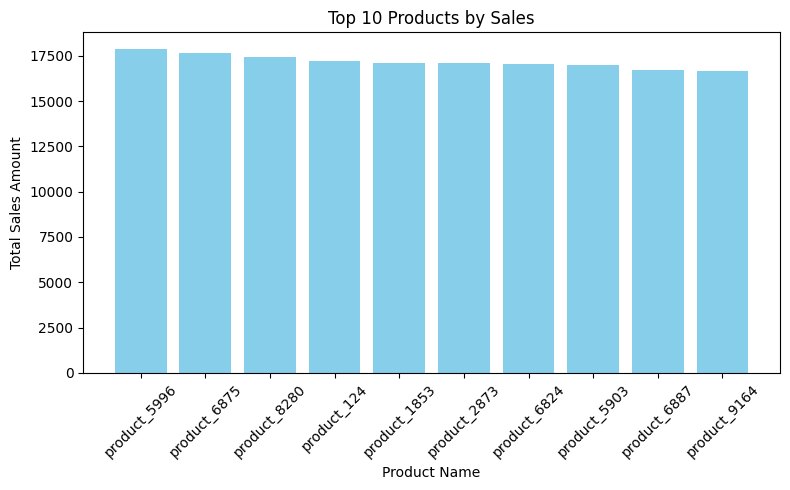

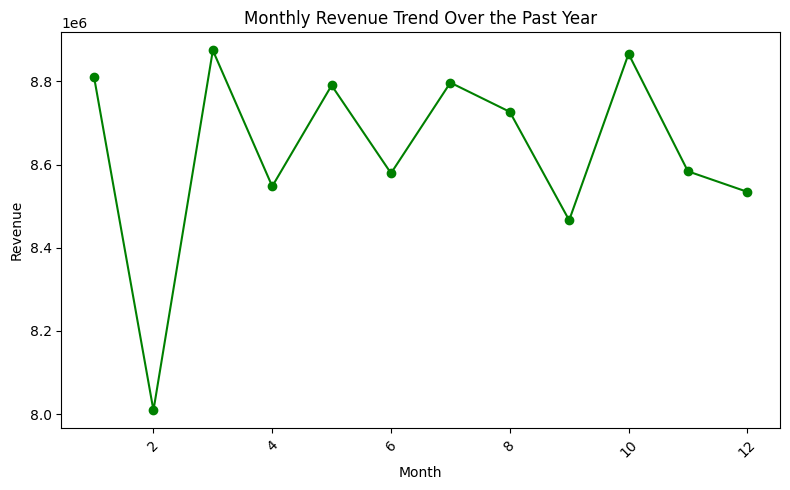

In [21]:
import matplotlib.pyplot as plt

# 1. Top Products by Sales Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(top_products_pd['product_name'], top_products_pd['total_sales'], color='skyblue')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product Name')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Revenue Trend Line Chart
plt.figure(figsize=(8, 5))
plt.plot(revenue_trend_pd['month'], revenue_trend_pd['revenue'], marker='o', color='green')
plt.title('Monthly Revenue Trend Over the Past Year')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [23]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

# Initialize Spark session and Streaming context
spark = SparkSession.builder.master("local[*]").appName("SocketStream").getOrCreate()
sc = spark.sparkContext
ssc = StreamingContext(sc, 1)  # Streaming batch interval of 1 second

# Define the hostname and port number of the socket server
hostname = "localhost"
port = 9999

# Create a DStream that connects to the socket
lines = ssc.socketTextStream(hostname, port)

# Process the incoming data and print each line for now
lines.pprint()

# Start streaming
ssc.start()
ssc.awaitTermination(60)  # Adjust the duration as needed



/usr/local/lib/python3.10/dist-packages/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


-------------------------------------------
Time: 2024-09-10 17:36:41
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:42
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:43
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:44
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:45
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:46
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:47
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:48
-------------------------------------------

-------------------------------------------
Time: 2024-09-10 17:36:49
----------